# Обработка и анализ данных из JSON файлов

Этот скрипт обрабатывает JSON файлы в указанной директории, объединяет их в один CSV-файл, ограничивает количество записей в каждой категории и визуализирует статистику.

In [7]:
!pip install pandas matplotlib

## Импорт библиотек

In [8]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Настройки

In [9]:
# Директория с JSON-файлами и путь для выходного CSV
input_directory = 'data'  # Папка с JSON-файлами
output_file = 'merged_output_all.csv'  # Путь к итоговому CSV-файлу

# Заголовки для CSV
header = ["message_id", "sender_id", "text", "date", "channel", "category"]

# Параметры для обработки данных
category_column = "category"  # Столбец с категориями
max_count_per_category = 1000  # Максимальное число записей на категорию
apply_limit = False  # Применять ограничение на число записей в категории

## Преобразование данных из JSON в CSV

In [10]:
def merge_json_to_csv(input_dir: str, output_csv: str, headers: list) -> None:
    """
    Читает все JSON-файлы из директории, преобразует их в формат CSV и сохраняет в указанный файл.
    
    Args:
        input_dir (str): Путь к директории с JSON-файлами.
        output_csv (str): Путь к выходному CSV-файлу.
        headers (list): Заголовки для итогового CSV.
    """
    with open(output_csv, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(headers)  # Записываем заголовки
        
        for filename in os.listdir(input_dir):
            if filename.endswith('.json'):  # Проверяем расширение файла
                file_path = os.path.join(input_dir, filename)
                
                try:
                    with open(file_path, 'r', encoding='utf-8') as json_file:
                        data = json.load(json_file)
                        if isinstance(data, list):  # Обрабатываем только списки
                            for entry in data:
                                row = [entry.get(key, "") for key in headers]
                                csv_writer.writerow(row)
                except json.JSONDecodeError as e:
                    print(f"Ошибка чтения {filename}: {e}")
                except Exception as e:
                    print(f"Неизвестная ошибка при обработке {filename}: {e}")

# Выполняем объединение JSON-файлов
merge_json_to_csv(input_directory, output_file, header)

## Ограничение количества записей на категорию

In [11]:
def limit_records_by_category(input_csv: str, output_csv: str, category_col: str, max_count: int) -> None:
    """
    Ограничивает число записей в каждой категории и сохраняет данные в новый CSV-файл.

    Args:
        input_csv (str): Путь к входному CSV-файлу.
        output_csv (str): Путь к выходному CSV-файлу.
        category_col (str): Название столбца с категориями.
        max_count (int): Максимальное число записей на категорию.
    """
    df = pd.read_csv(input_csv)
    if category_col not in df.columns:
        raise ValueError(f"Столбец '{category_col}' не найден в датасете.")

    capped_df = (
        df.groupby(category_col)
        .apply(lambda group: group.sample(min(len(group), max_count), random_state=42))
        .reset_index(drop=True)
    )
    capped_df.to_csv(output_csv, index=False)

# Ограничиваем число записей на категорию (если требуется)
if apply_limit:
    limit_records_by_category(output_file, output_file, category_column, max_count_per_category)

## Построение графиков

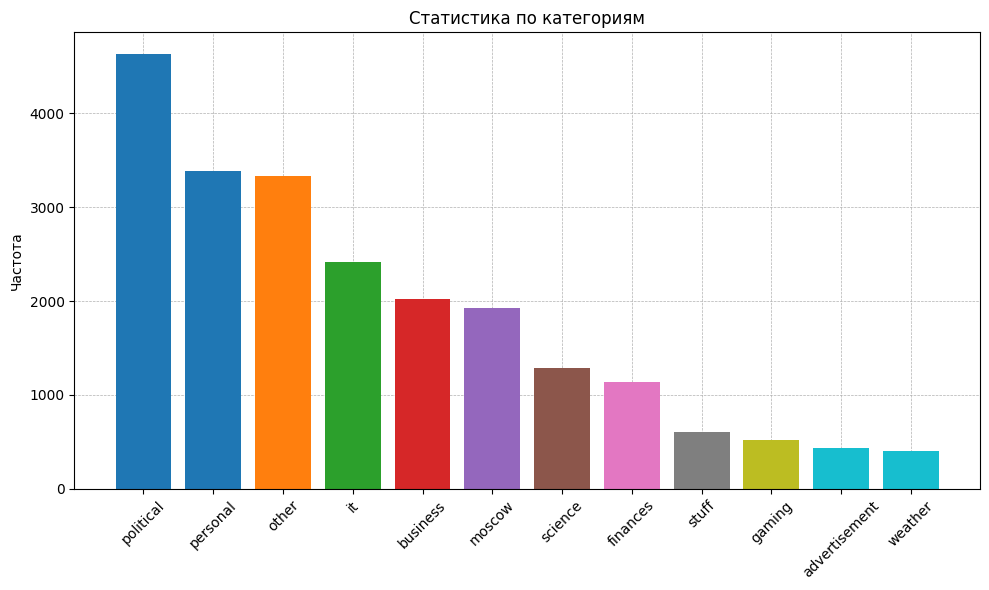

In [14]:
def plot_from_csv(csv_file: str) -> None:
    """
    Строит столбчатую диаграмму на основе данных из CSV-файла.

    Args:
        csv_file (str): Путь к файлу CSV.
    """
    data = pd.read_csv(csv_file)

    if "category" not in data.columns:
        raise ValueError(f"Столбец 'category' отсутствует в указанном CSV-файле.")

    category_counts = data["category"].value_counts()
    colors = plt.cm.tab10(np.linspace(0, 1, len(category_counts)))

    plt.figure(figsize=(10, 6))
    plt.bar(category_counts.index, category_counts.values, color=colors, zorder=2)
    plt.title("Статистика по категориям")
    plt.ylabel("Частота")
    plt.xticks(rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)
    plt.tight_layout()
    plt.show()

# Пример использования функции
plot_from_csv(output_file)